# Basic tools

In [1]:
%matplotlib inline
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_mean_std(save_dir, model, dist, postfix, samplings):
    """
    Args:
        model: str, 'MLP' or 'NaiveCNN'
        dist: str, 'Dirichlet_0.1', 'Dirichlet_0.3', 'Dirichlet_0.5', 'uniform'
        postfix: str, 'dir01', 'dir03', 'dir05', 'unif'
        samplings: list, ['Random', 'LossSampling', 'GradientBADGE', 'powd2', 'powd3', 'powd5', 'FedCor']
    """
    seeds = range(10)
    pkls = ['acc'+str(i)+'.pkl' for i in seeds]
    bins = ['bin_'+str(i)+'.csv' for i in seeds]

    acc_dict = dict()
    csv_dict = dict()

    for sample in samplings:
        if sample[:-1] == 'powd':
            d = sample[-1]
            pkl_dir = '_'.join([model, 'powd', dist, postfix+d])
        else:
            pkl_dir = '_'.join([model, sample, dist, postfix])
        acc_dict[sample] = list()
        csv_dict[sample] = list()
        # parse pkl
        for pkl in pkls:
            pkl_path = os.path.join(save_dir, pkl_dir, pkl)
            try:
                with open(pkl_path, 'rb') as f:
                    acc = pickle.load(f)
            except:
                print('No file', pkl_path)
                continue
            acc_dict[sample].append(acc)

        # parse bin
        for bin in bins:
            bin_path = os.path.join(save_dir, pkl_dir, bin)
            try:
                with open(bin_path, 'rb') as f:
                    csv_txt = np.loadtxt(f, delimiter=',')
            except:
                print('No file', bin_path)
                continue
            csv_dict[sample].append(csv_txt)

    mean_dict = dict()
    std_dict = dict()

    for sample in samplings:
        mean_dict[sample] = np.mean(acc_dict[sample], axis=0)
        std_dict[sample] = np.std(acc_dict[sample], axis=0)

    return mean_dict, std_dict, csv_dict


def get_client_info(csv_arr):
    """
    Args:
        csv_arr: np.array (num_client, 3) id, activated, size
    """
    client_activated = csv_arr[:,1]
    client_size = csv_arr[:,2]

    return client_activated, client_size
    

# Plotting Graph

In [18]:
dataset = 'cifar10' # 'cifar10' or 'fmnist'
rounds = 2000

In [19]:
save_root = './save'
save_dir = os.path.join(save_root, dataset)

out_root = './outs'

if dataset == 'fmnist':
    model = 'MLP'
elif dataset in ['cifar10', 'cifar100']:
    model = 'NaiveCNN'
dist = ['Dirichlet_0.1', 'Dirichlet_0.3', 'Dirichlet_0.5', 'uniform', 'shard_1', 'shard_2']
#dist = ['Dirichlet_0.1', 'Dirichlet_0.3', 'Dirichlet_0.5', 'shard_1', 'shard_2']
postfix = ['dir01', 'dir03', 'dir05', 'unif', 'spc1', 'spc2']
#postfix = ['dir01', 'dir03', 'dir05', 'spc1', 'spc2']
#pf = 'dir03'
samplings = ['Random', 'LossSampling', 'GradientBADGE', 'powd2', 'powd3', 'powd5', 'FedCor']
#samplings = ['FedCor', 'Random']
mean_list, std_list, csv_list = [], [], []

for d, pf in zip(dist, postfix):
    print(d, pf)
    mean_dict, std_dict, csv_dict = get_mean_std(save_dir, model, d, pf, samplings)
    mean_list.append(mean_dict)
    std_list.append(std_dict)
    csv_list.append(csv_dict)

Dirichlet_0.1 dir01
Dirichlet_0.3 dir03
Dirichlet_0.5 dir05
uniform unif
shard_1 spc1
shard_2 spc2


## Main accuracy plotting

In [20]:
def plot_test_accuracy(mean_list, std_list, idx, rounds, ax):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # plot test accuracy
    for key in mean_list[idx].keys():
        x_bar = np.arange(rounds)

        mean = mean_list[idx][key][:rounds]
        std = std_list[idx][key][:rounds]
        color = colors.pop()
        ax.plot(x_bar, mean, color=color, label=key)
        ax.fill_between(x_bar, mean-std, mean+std, color=color, alpha=0.2)

    x_label = 'communication rounds'
    y_label = 'test accuracy'
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title('Test accuracy')
    ax.legend()   

def plot_test_difference(mean_list, idx, rounds, ax):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    color = colors.pop()
    random_mean = mean_list[idx]['Random'][:rounds]

    for key in mean_list[idx].keys():
        if key == 'Random':
            continue
        mean = mean_list[idx][key][:rounds]
        color = colors.pop()
        label = key
        ax.plot(range(rounds), mean-random_mean, color=color, label=label)

    x_label = 'communication rounds'
    y_label = 'test accuracy differnce (random sampling)'
    ax.set(xlabel=x_label, ylabel=y_label)

    ax.set_title('Difference w.r.t Random')

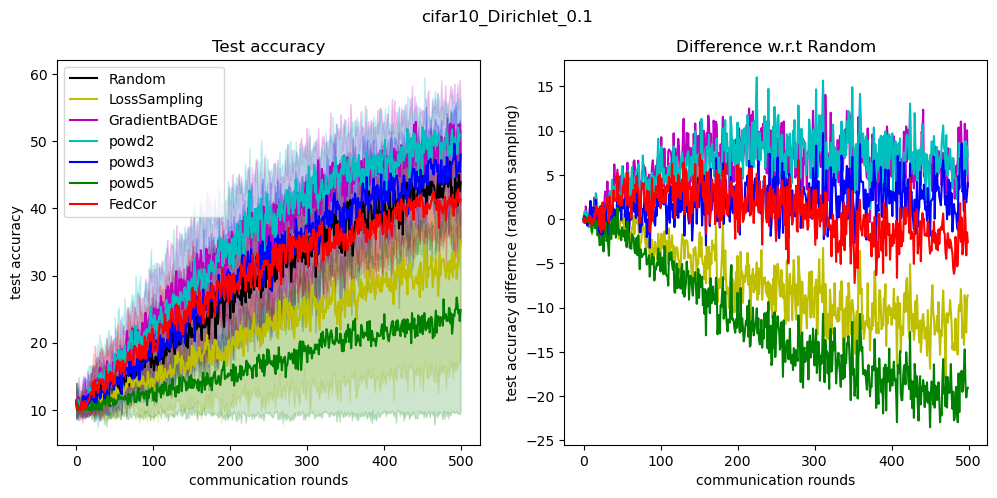

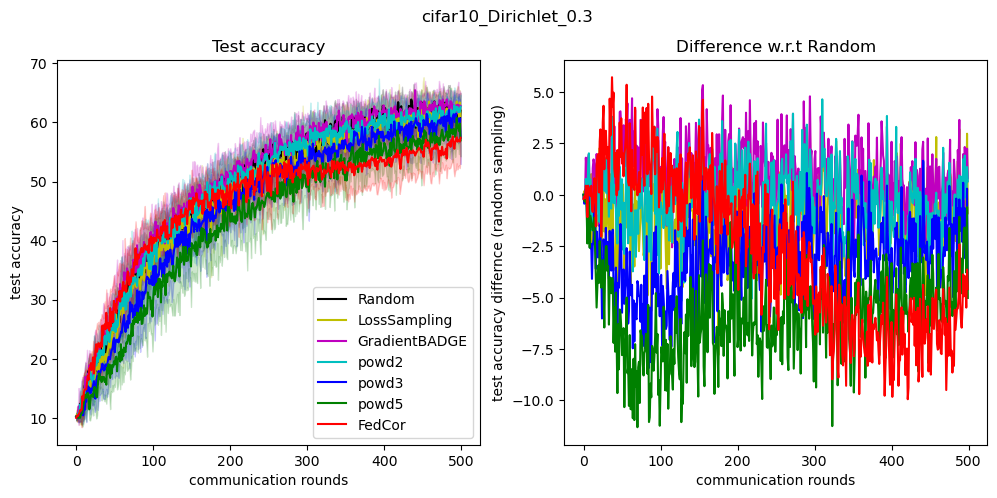

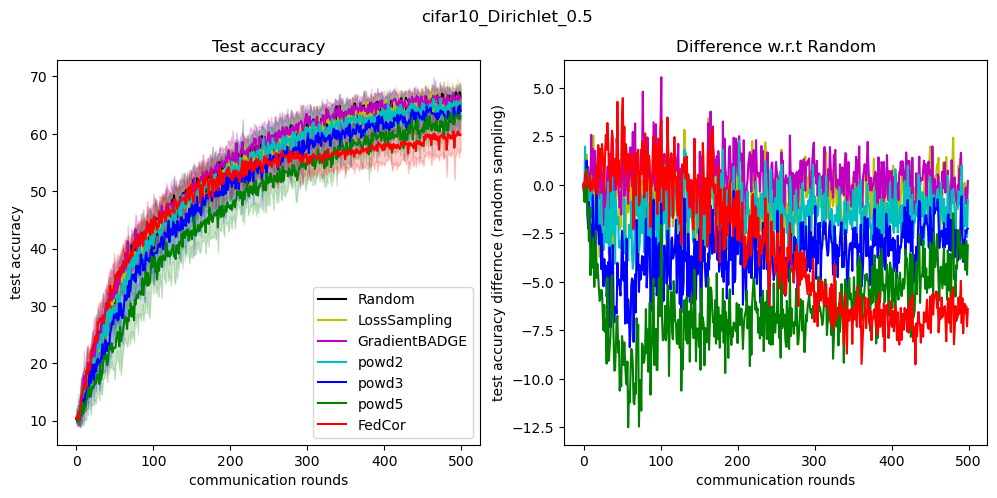

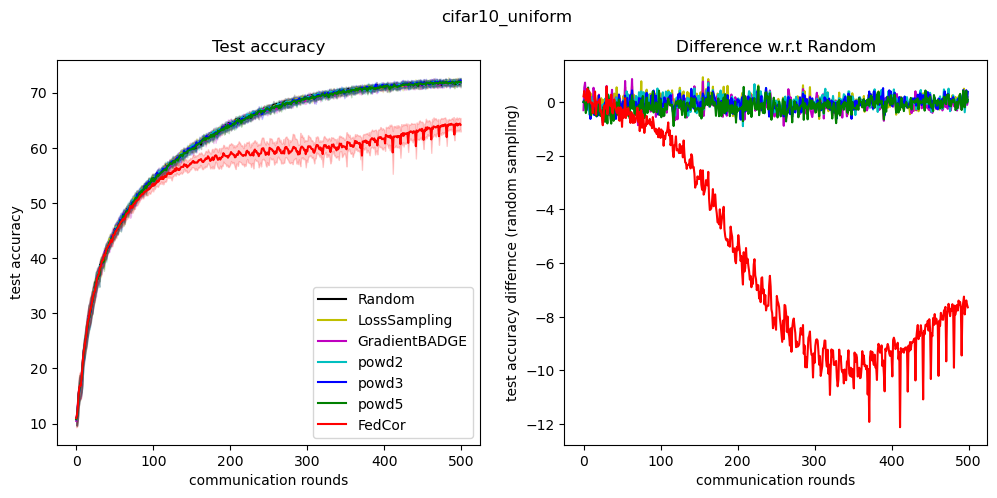

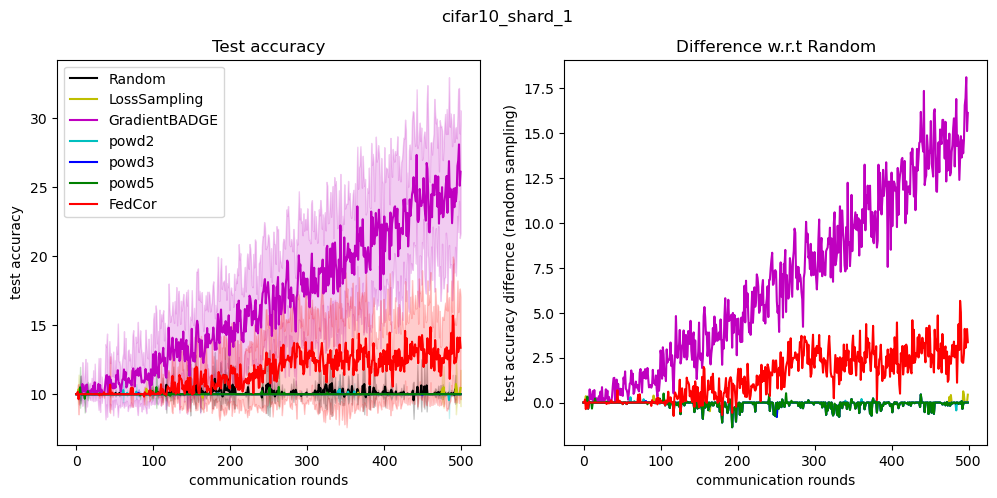

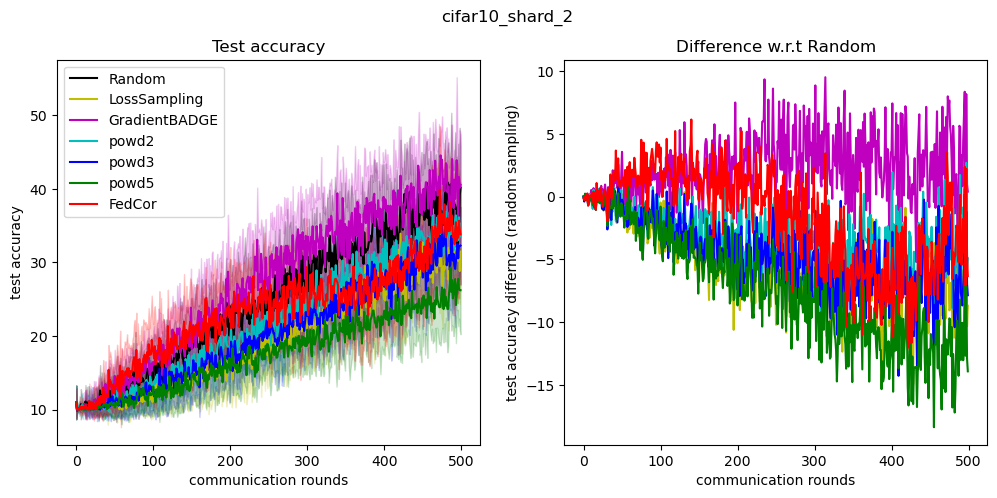

In [21]:
N = 100
C = 5
rounds = 500

for idx in range(len(dist)):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # plot test accuracy difference
    ax = axs[0]
    plot_test_accuracy(mean_list, std_list, idx, rounds, ax)

    ax = axs[1]
    plot_test_difference(mean_list, idx, rounds, ax)

    distribution = dist[idx]

    title = '_'.join([dataset, distribution])
    plt.suptitle(title)

    path = os.path.join(out_root, title+'.png')
    plt.savefig(path)

# Client selection information

/tmp/ipykernel_2545779/3720726040.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(12,5))


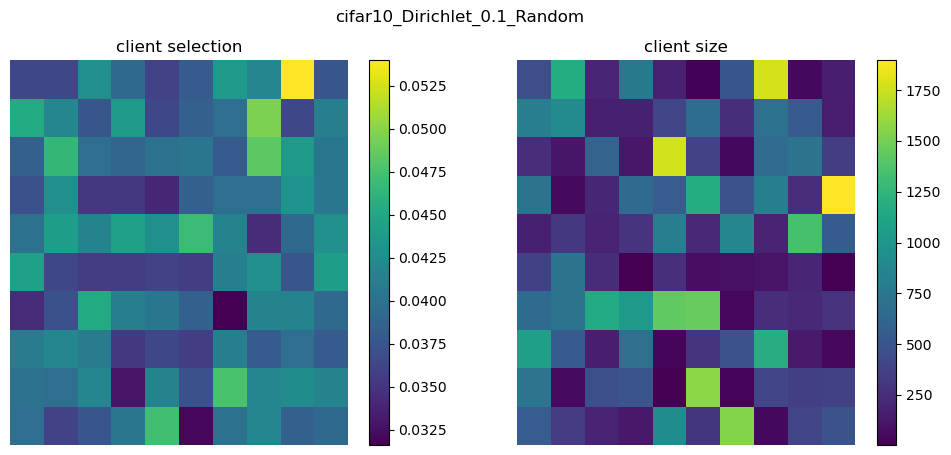

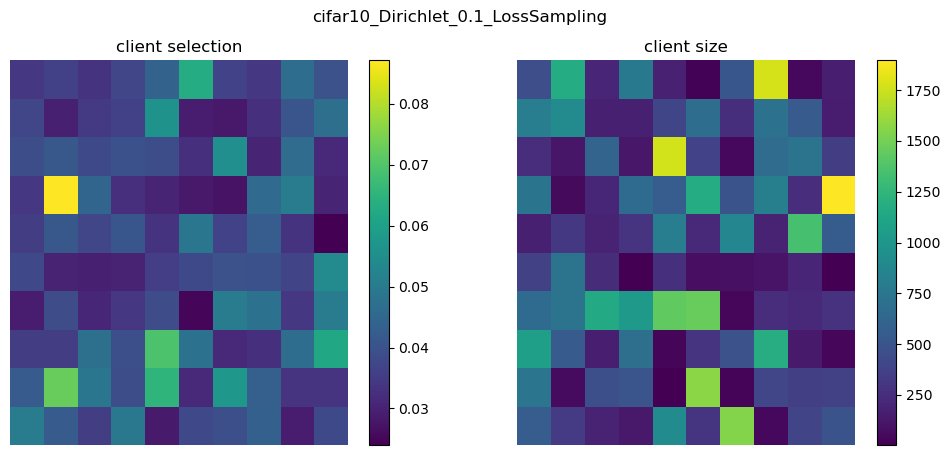

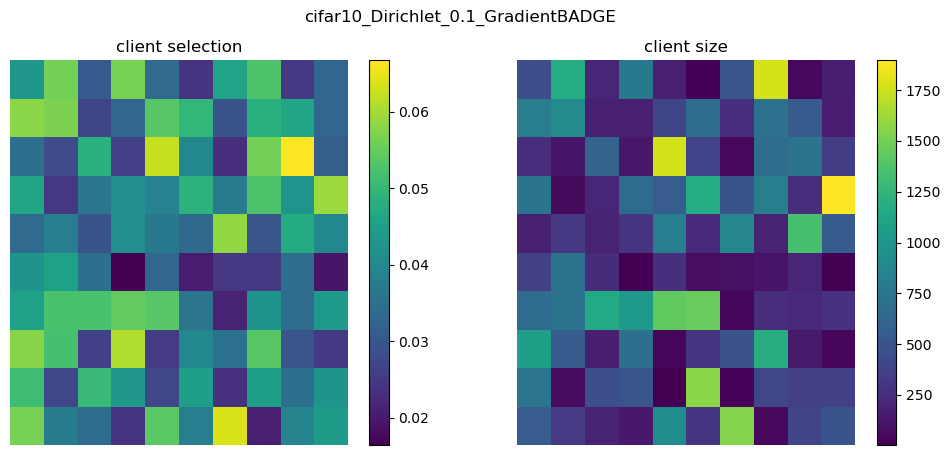

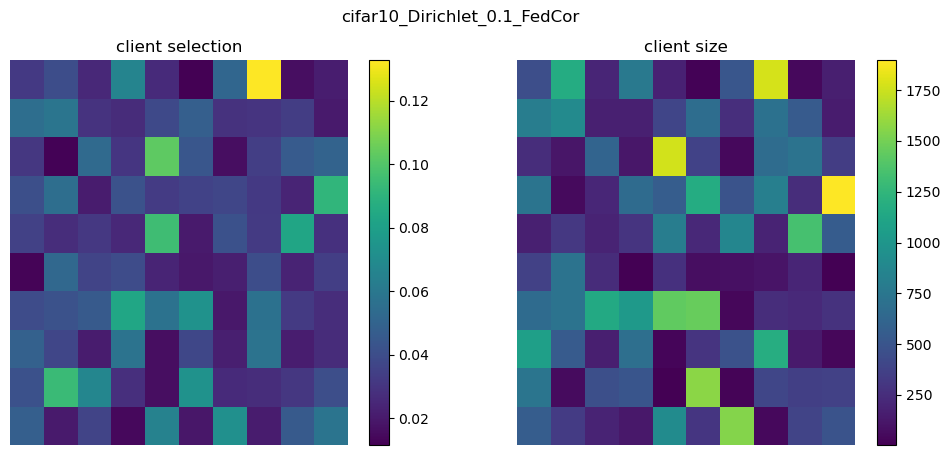

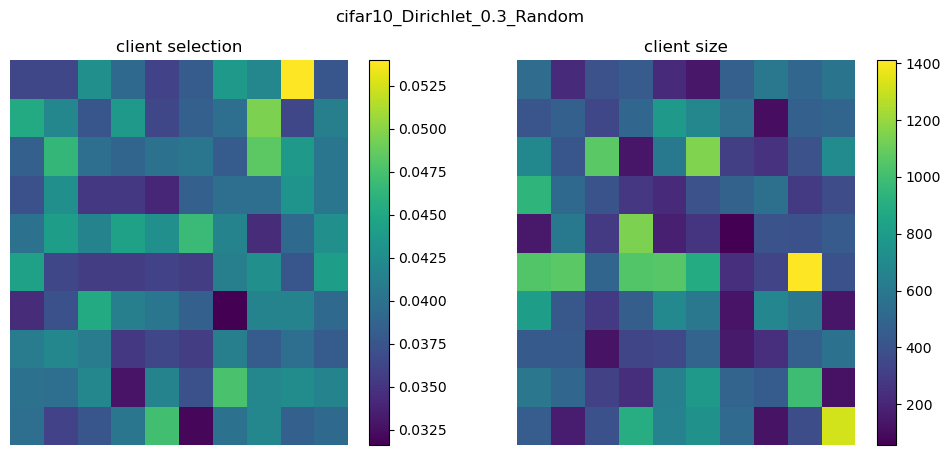

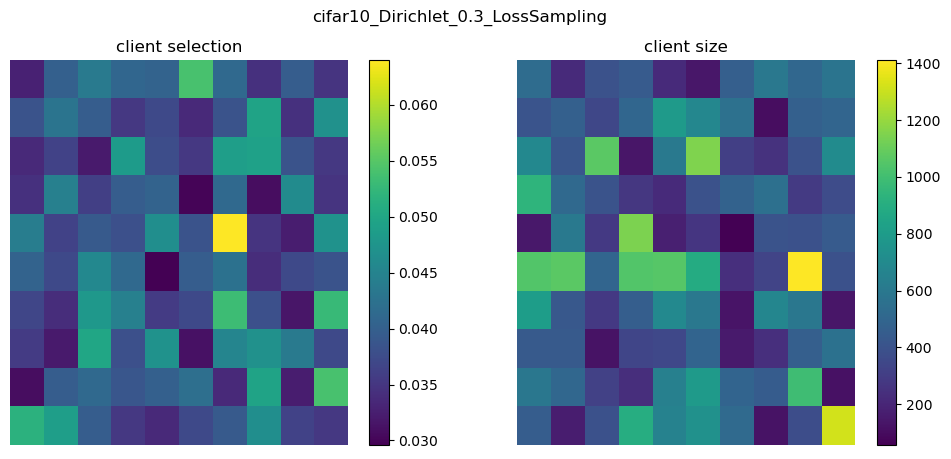

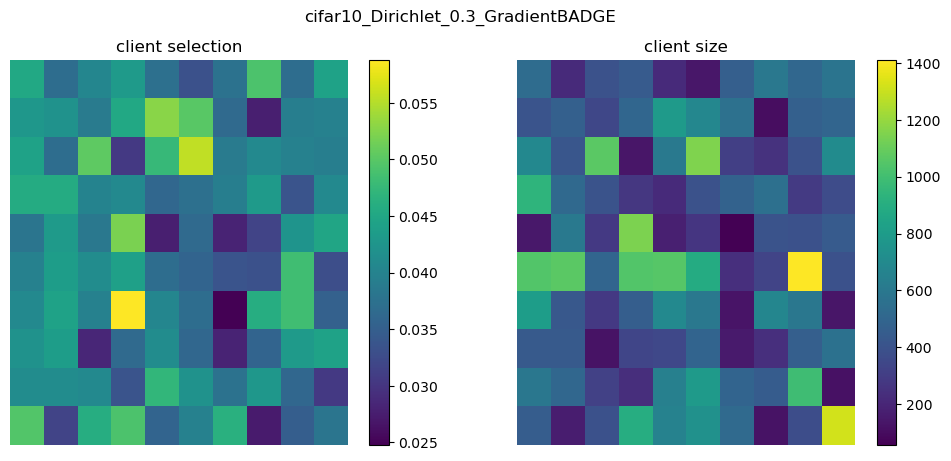

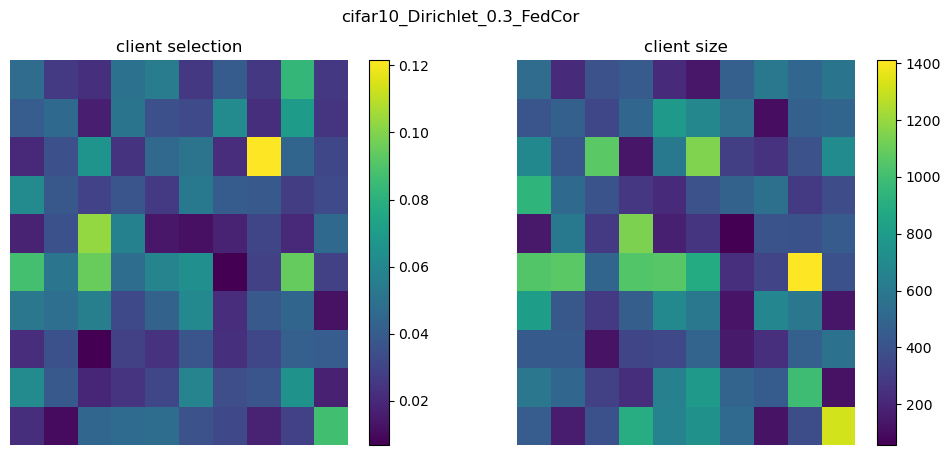

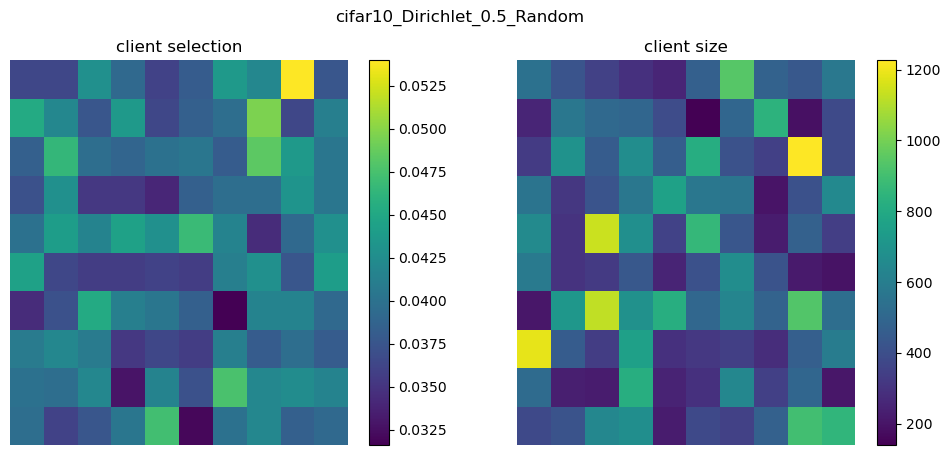

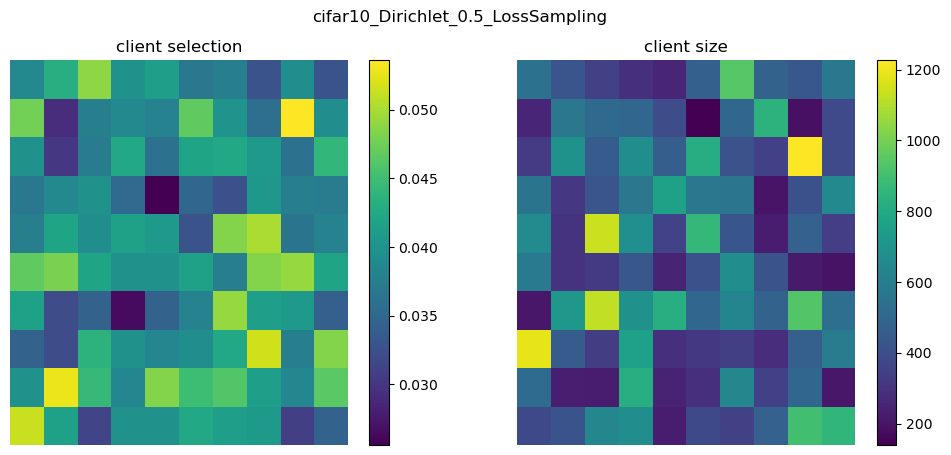

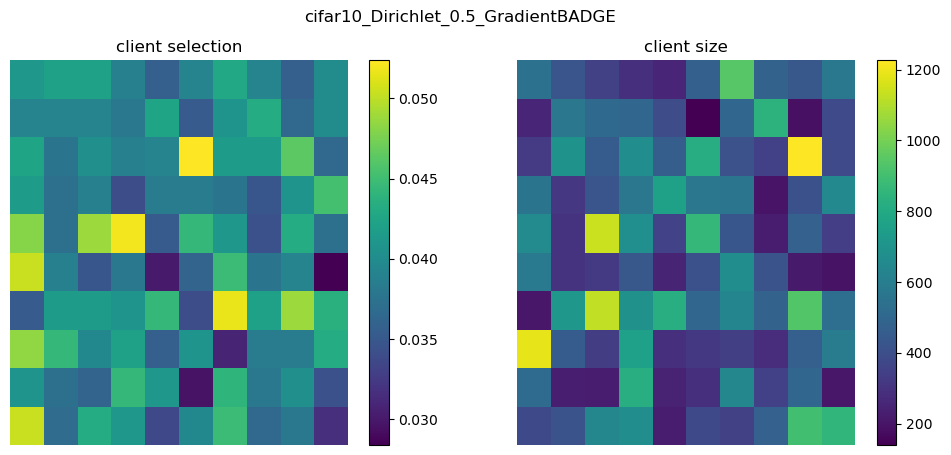

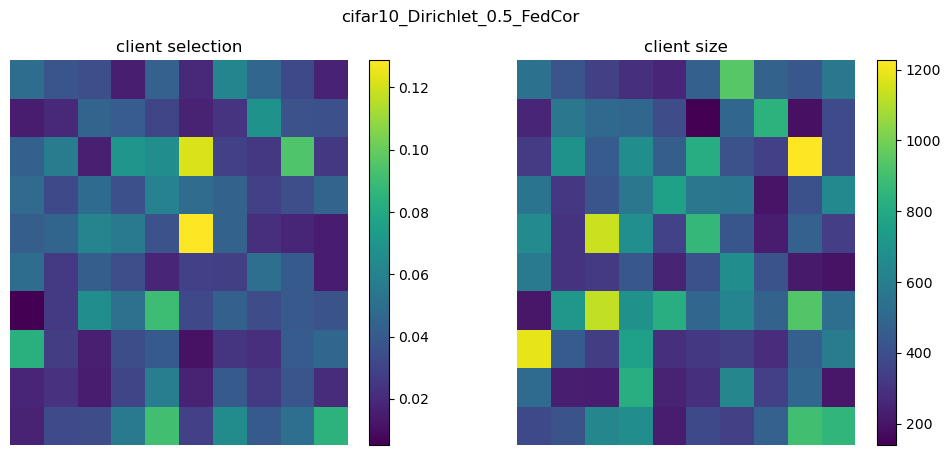

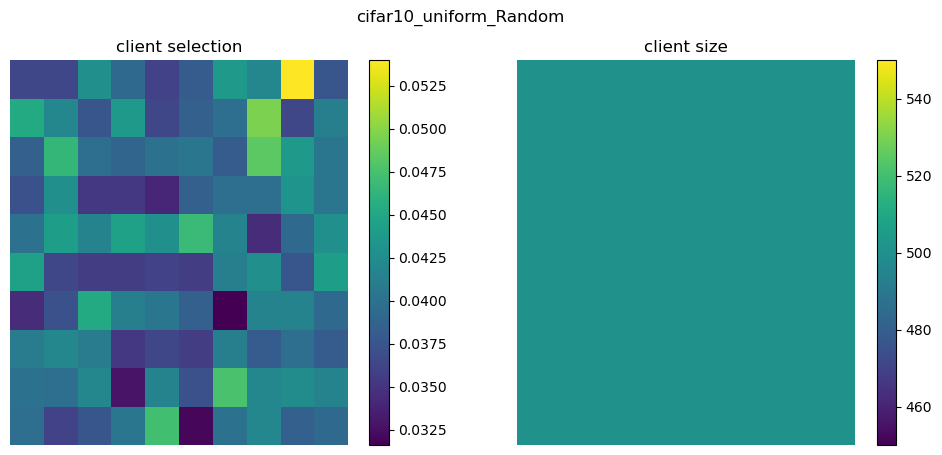

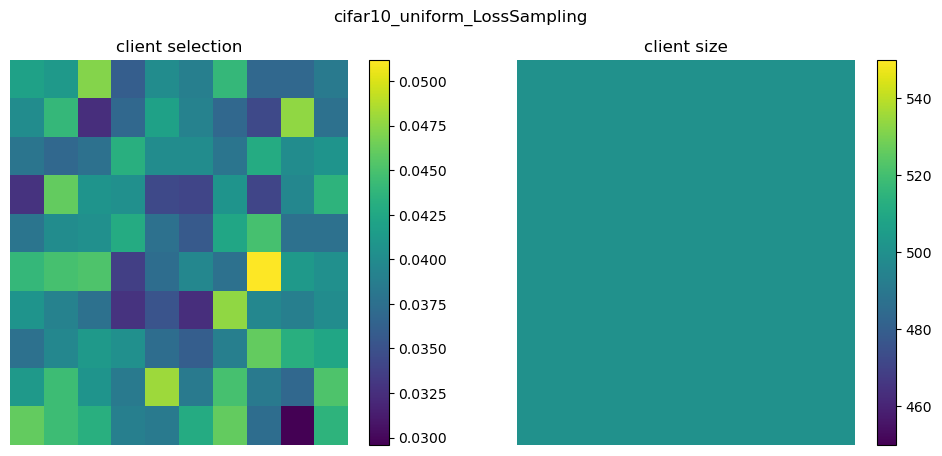

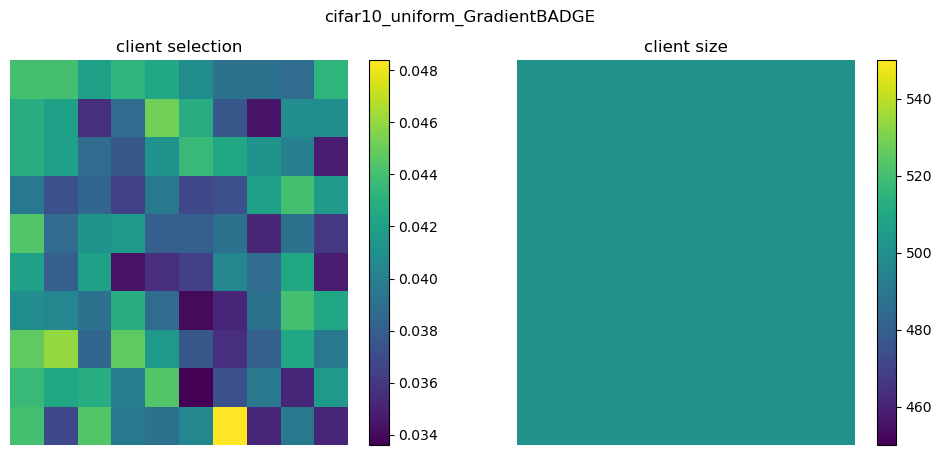

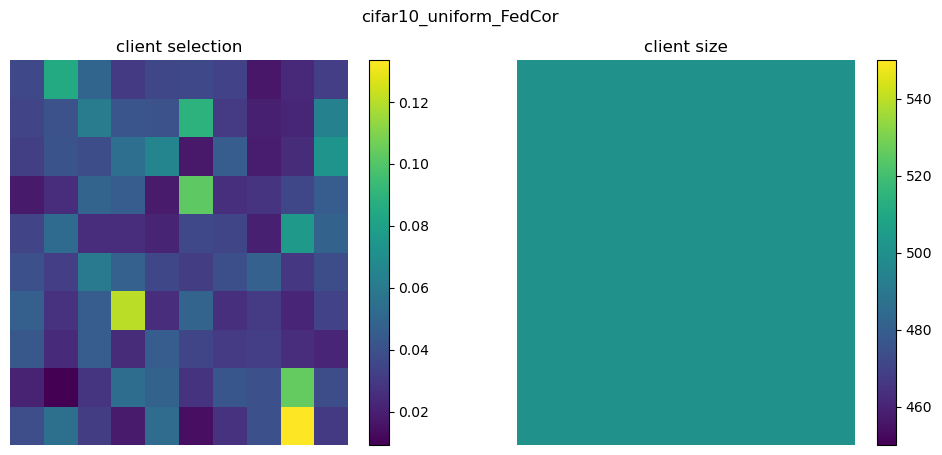

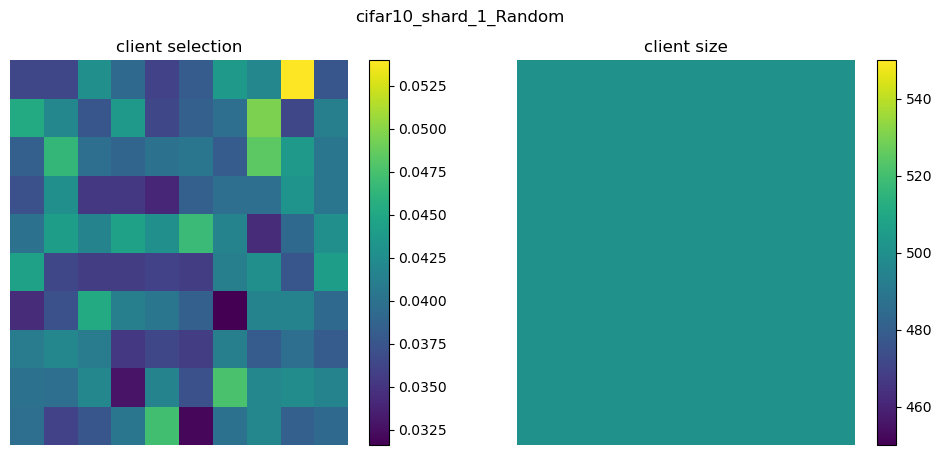

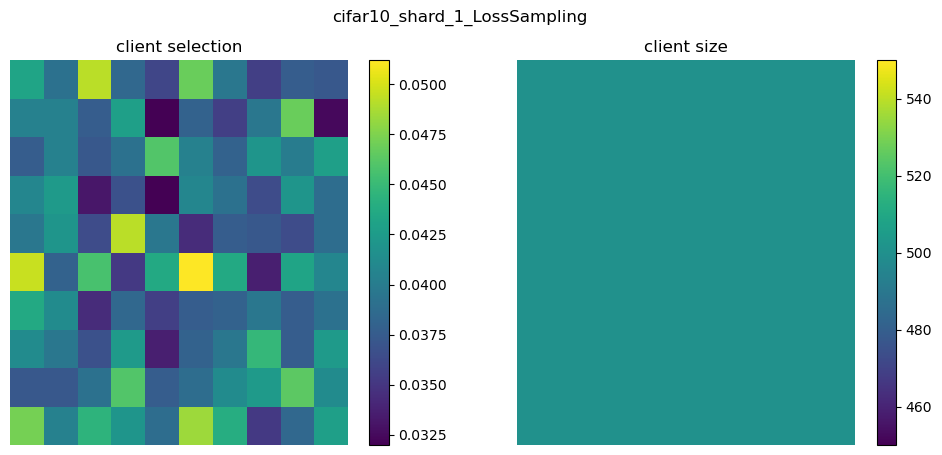

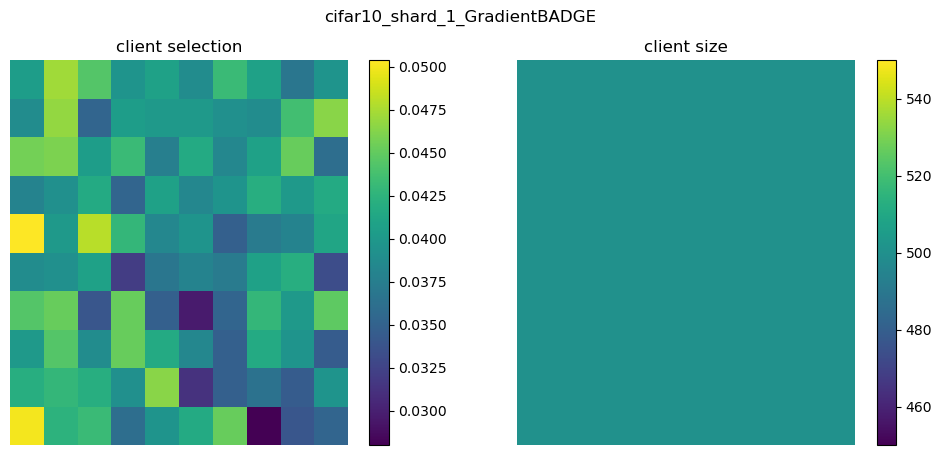

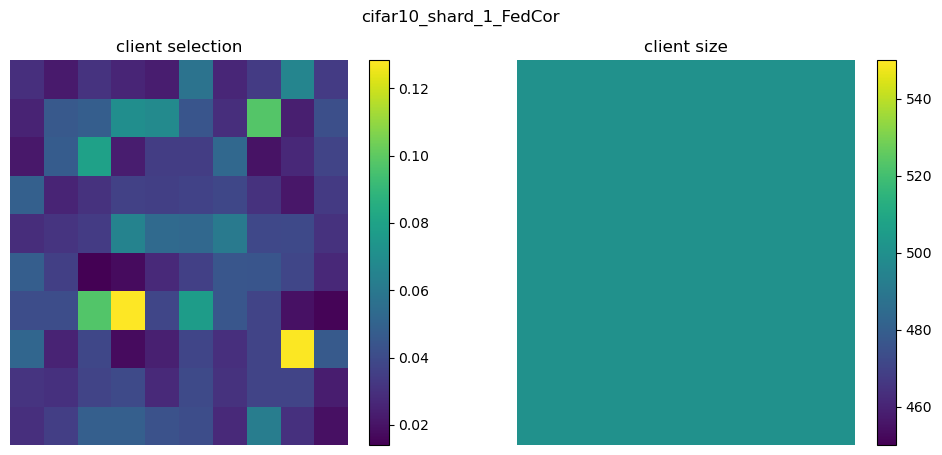

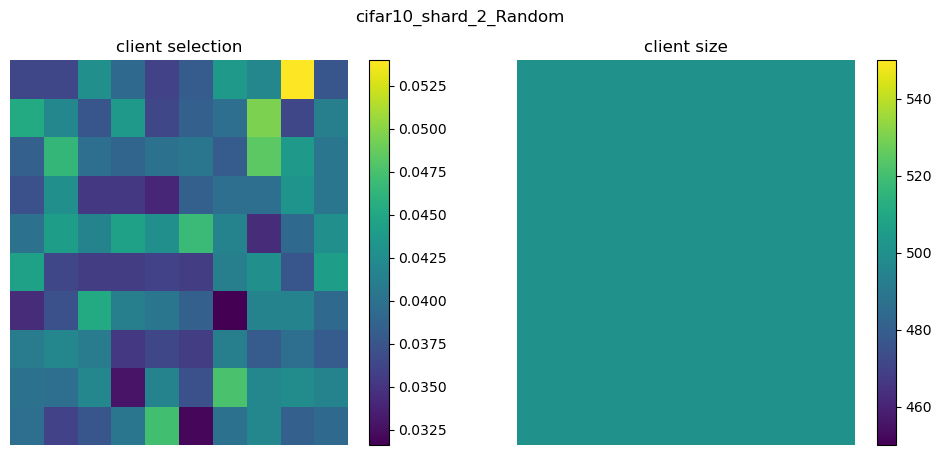

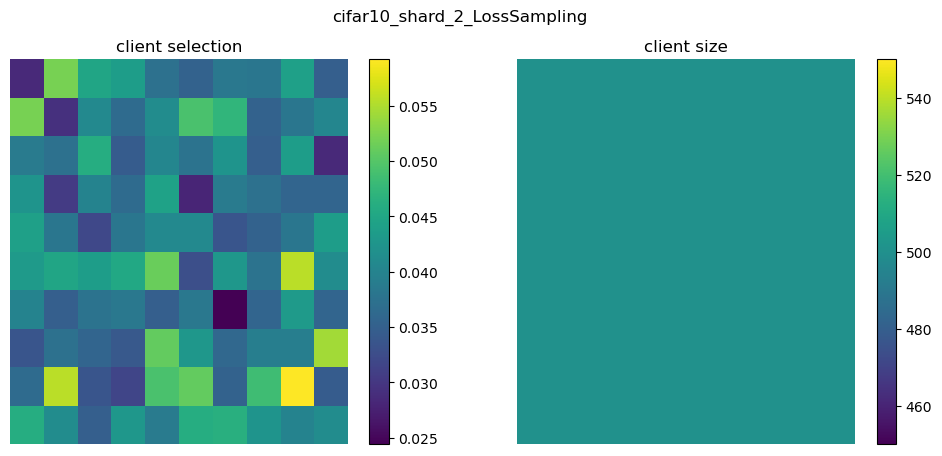

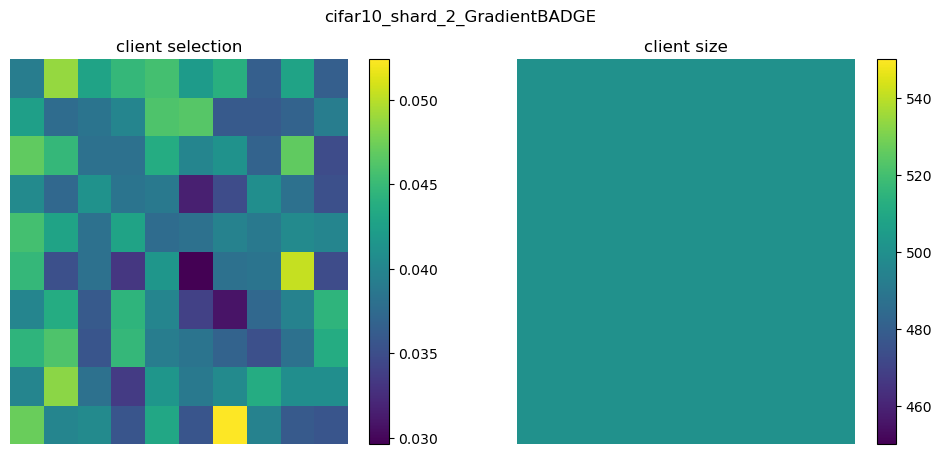

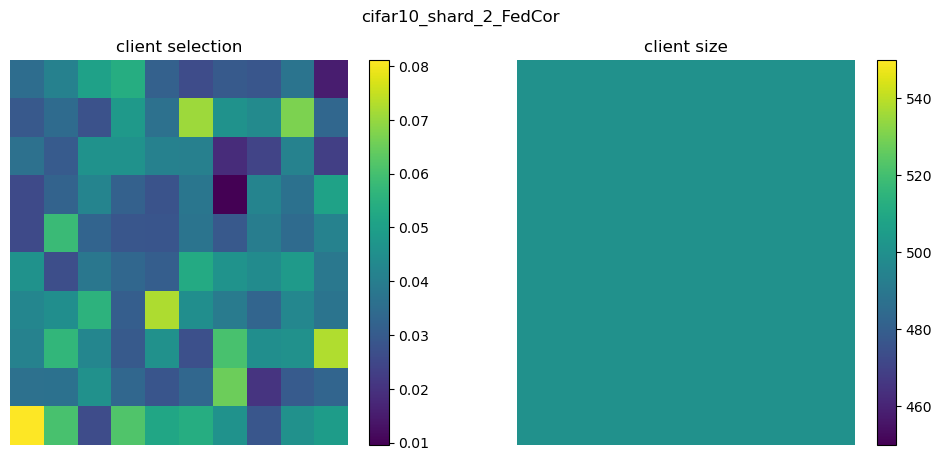

In [22]:
for idx in range(len(dist)):
    distribution = dist[idx]
    samplings = ['Random', 'LossSampling', 'GradientBADGE', 'FedCor']
    for method in samplings:
        c = csv_list[idx][method][0]
        selects, clsz = get_client_info(c)
        selects = selects / (500 * 5)
        fig, axs = plt.subplots(1, 2, figsize=(12,5))

        ax = axs[0]
        msh = ax.pcolormesh(selects.reshape(10,10))
        ax.axis('off')
        ax.set_title('client selection')
        fig.colorbar(msh, ax=axs[0])

        sz_plt = axs[1]
        msh = sz_plt.pcolormesh(clsz.reshape(10,10))
        sz_plt.axis('off')
        sz_plt.set_title('client size')
        fig.colorbar(msh, ax=axs[1])

        title = '_'.join([dataset, distribution, method])
        plt.suptitle(title)

        path = os.path.join(out_root, title+'.png')
        plt.savefig(path)